In [1]:
!nvidia-smi

Sun Aug 24 05:06:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Import And Split**

In [2]:
# ============================================================
# 0. Setup
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset paths
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_baseline")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# Custom folder for all outputs
OUTPUT_FOLDER = Path("/kaggle/working/base_yolov11")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. VOC → YOLO conversion + train/val/test split
# ============================================================
def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    all_pairs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))

    print(f"Found {len(all_pairs)} annotated images total.")
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "val":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

# Create data.yaml for YOLOv11
DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready:", DATA)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

**Train Yolo Baseline**

In [3]:
# ============================================================
# 2. Train YOLOv11 baseline (outputs in custom folder)
# ============================================================
model = YOLO("yolo11s.pt")  # baseline small version
model.train(
    data=str(DATA),
    epochs=50,        # increase if resources allow
    imgsz=640,
    batch=16,
    workers=2,
    project=str(OUTPUT_FOLDER),  # <- save all outputs here
    name="train"                 # <- folder name inside project
)


Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_baseline/data_traffic.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1179.4±578.4 MB/s, size: 73.6 KB)


train: Scanning /kaggle/working/traffic_baseline/yolo_split/train/labels... 16574 images, 38 backgrounds, 0 corrupt: 100%|██████████| 16574/16574 [00:11<00:00, 1422.27it/s]

train: /kaggle/working/traffic_baseline/yolo_split/train/images/frame1_jpg.rf.af73293c83d849389bfeacd60c71cd38.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/traffic_baseline/yolo_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1314.5±738.0 MB/s, size: 63.3 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/val/labels... 4735 images, 11 backgrounds, 0 corrupt: 100%|██████████| 4735/4735 [00:03<00:00, 1336.17it/s]

val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame0_jpg.rf.e1bc04102d10d13d3e4801450a664640.jpg: 2 duplicate labels removed
val: /kaggle/working/traffic_baseline/yolo_split/val/images/frame195_jpg.rf.46fd02322bca0e4c4437d57807d7a178.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/traffic_baseline/yolo_split/val/labels.cache
Plotting labels to /kaggle/working/base_yolov11/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/base_yolov11/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.08G      1.429      1.257      1.117        222        640: 100%|██████████| 1036/1036 [04:58<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:34<00:00,  4.29it/s]


                   all       4735      46375      0.583      0.591      0.629      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.36G      1.317      0.954      1.047        308        640: 100%|██████████| 1036/1036 [04:55<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.593      0.629      0.647      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.38G      1.323     0.9627      1.055        177        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]


                   all       4735      46375      0.547      0.641      0.621      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.41G      1.313     0.9544      1.055        213        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.583      0.646      0.644      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.44G      1.282     0.9185      1.046        286        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.608      0.628      0.657      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.46G      1.255     0.8913      1.039        290        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]


                   all       4735      46375      0.617       0.67      0.683      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.49G      1.241     0.8733      1.031        300        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.628      0.676      0.685      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.52G      1.226     0.8543      1.029        265        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.652       0.66      0.695      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.54G      1.215      0.843      1.023        273        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.609      0.671      0.684      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.57G      1.201     0.8307       1.02        295        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.661      0.662       0.69      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.6G      1.189     0.8156      1.014        253        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.648      0.681      0.712      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.62G      1.184     0.8118      1.012        203        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.673      0.671      0.702      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.65G      1.177     0.8019      1.009        161        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.44it/s]


                   all       4735      46375      0.636      0.687      0.713      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.68G      1.169     0.7938      1.006        273        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.42it/s]


                   all       4735      46375      0.679      0.667      0.714      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       4.7G      1.163     0.7892      1.003        249        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.644      0.688      0.713      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.73G      1.156     0.7819      1.003        200        640: 100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375       0.67      0.688      0.726       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.76G       1.15     0.7737     0.9989        205        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.42it/s]


                   all       4735      46375      0.646        0.7      0.721      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.78G      1.144     0.7692     0.9974        205        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.655      0.689      0.722      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.81G      1.139     0.7637     0.9943        256        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.44it/s]


                   all       4735      46375      0.637      0.702      0.727      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.84G      1.134     0.7583     0.9938        175        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.42it/s]


                   all       4735      46375      0.652      0.716      0.734       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.86G      1.129     0.7511      0.992        208        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.42it/s]


                   all       4735      46375      0.676      0.699      0.739      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.89G      1.121     0.7465       0.99        193        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.43it/s]


                   all       4735      46375      0.651      0.713      0.738      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.91G      1.117     0.7402     0.9881        185        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.668      0.704      0.743        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.94G      1.112     0.7355     0.9852        276        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.676       0.71      0.741      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.97G      1.109     0.7335     0.9864        159        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.44it/s]


                   all       4735      46375      0.682      0.703       0.74      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.99G      1.103     0.7263     0.9828        239        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:34<00:00,  4.35it/s]


                   all       4735      46375      0.686      0.699      0.742      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.02G      1.098     0.7228      0.981        202        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]


                   all       4735      46375       0.66       0.71      0.744      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.05G      1.095     0.7185     0.9787        228        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.38it/s]


                   all       4735      46375      0.684      0.707      0.746      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.07G      1.087     0.7103     0.9761        279        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]


                   all       4735      46375      0.676      0.703       0.74      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.23G      1.083      0.707     0.9742        225        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.676      0.703      0.743      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.26G      1.078     0.7011     0.9732        229        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375       0.69      0.696      0.747      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.29G      1.077      0.699     0.9731        251        640: 100%|██████████| 1036/1036 [04:53<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.685      0.707      0.745      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.31G      1.067     0.6925     0.9702        183        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.37it/s]


                   all       4735      46375      0.684      0.698      0.746      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.34G      1.065     0.6899     0.9691        216        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.36it/s]


                   all       4735      46375       0.69      0.692      0.744      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.37G      1.056     0.6826     0.9662        178        640: 100%|██████████| 1036/1036 [04:53<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.38it/s]


                   all       4735      46375      0.695      0.691      0.741      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.39G      1.055     0.6794     0.9651        243        640: 100%|██████████| 1036/1036 [04:53<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]


                   all       4735      46375      0.721      0.669      0.742      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.42G      1.047     0.6735     0.9624        233        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]


                   all       4735      46375      0.673      0.711      0.744      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.45G      1.042     0.6678     0.9621        207        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]


                   all       4735      46375      0.671      0.711      0.742      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.47G      1.041      0.665     0.9613        216        640: 100%|██████████| 1036/1036 [04:53<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]

                   all       4735      46375      0.668       0.71      0.742      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       5.5G      1.032     0.6584     0.9587        244        640: 100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.37it/s]

                   all       4735      46375      0.693      0.687      0.742      0.509


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.52G      1.017     0.6243     0.9554        117        640: 100%|██████████| 1036/1036 [04:48<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]

                   all       4735      46375      0.697      0.692      0.744      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.55G      1.004      0.613     0.9514        160        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.38it/s]

                   all       4735      46375      0.685      0.704      0.746      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.58G     0.9947     0.6048     0.9478        138        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]

                   all       4735      46375      0.696      0.697      0.747      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       5.6G     0.9854     0.5971     0.9455        108        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.38it/s]

                   all       4735      46375      0.707      0.689      0.746      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.63G     0.9789      0.589     0.9417        125        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.40it/s]

                   all       4735      46375      0.708      0.682      0.743      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.66G     0.9722     0.5831     0.9409        134        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:34<00:00,  4.35it/s]

                   all       4735      46375      0.697      0.693      0.742      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.68G     0.9651     0.5758     0.9378        132        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.38it/s]

                   all       4735      46375       0.67      0.715      0.742      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.71G     0.9584     0.5702     0.9345        129        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:34<00:00,  4.35it/s]

                   all       4735      46375      0.672      0.715       0.74       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.74G     0.9515     0.5643     0.9334        135        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.41it/s]

                   all       4735      46375      0.678      0.708       0.74       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.76G     0.9436     0.5583     0.9308        152        640: 100%|██████████| 1036/1036 [04:47<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:33<00:00,  4.39it/s]

                   all       4735      46375      0.679      0.708      0.739      0.509



50 epochs completed in 4.527 hours.
Optimizer stripped from /kaggle/working/base_yolov11/train/weights/last.pt, 19.2MB
Optimizer stripped from /kaggle/working/base_yolov11/train/weights/best.pt, 19.2MB

Validating /kaggle/working/base_yolov11/train/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,283 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 148/148 [00:36<00:00,  4.07it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46375      0.695      0.697      0.747      0.513
              Rickshaw       3886      12129      0.782      0.857      0.903      0.629
                   Bus       3874      10310      0.787      0.845      0.891      0.648
                 Truck        251        278      0.475      0.493      0.488      0.379
                  Bike       2106       3100      0.766      0.769      0.853      0.526
                People       2930       7688      0.774      0.792      0.863       0.55
                   Car       4270      12732      0.832      0.886      0.936      0.706
                 Cycle        131        138      0.447      0.239      0.293      0.153
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/base_yolov11/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea3a32c6dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

**Evaluate**

In [4]:
# ============================================================
# 3. Evaluate on test set + generate plots (outputs in same folder)
# ============================================================
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,
    project=str(OUTPUT_FOLDER),  # <- same output folder
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,283 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1344.0±475.0 MB/s, size: 68.1 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels... 2369 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:01<00:00, 1423.80it/s]

val: New cache created: /kaggle/working/traffic_baseline/yolo_split/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:26<00:00,  5.58it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      23544      0.657      0.726      0.751      0.519
              Rickshaw       1947       6157      0.756      0.887       0.91      0.633
                   Bus       1954       5346      0.766      0.877      0.895       0.66
                 Truck        109        125       0.41      0.528      0.505      0.404
                  Bike       1034       1589      0.731      0.815      0.849      0.514
                People       1448       3878      0.723      0.828      0.862      0.548
                   Car       2143       6369        0.8      0.912      0.937      0.711
                 Cycle         77         80      0.409      0.237      0.301      0.161
Speed: 0.3ms preprocess, 7.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/base_yolov11/val
mAP@0.5     : 0.7513965381378961
mAP@[.5:.95]: 0.518800372995226
Precision   : 0.6565701860832126
Recall      : 0.7262122094841097


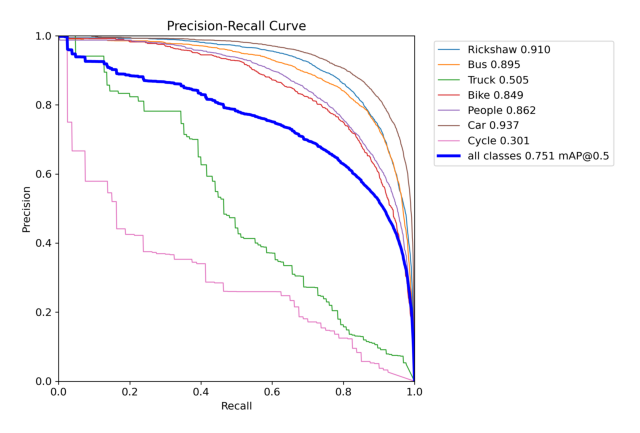

In [5]:
# ============================================================
# 4. Visualize PR curve from custom folder
# ============================================================
pr_curve_file = list((OUTPUT_FOLDER/"val").glob("*PR_curve*.png"))[0]
img = mpimg.imread(pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

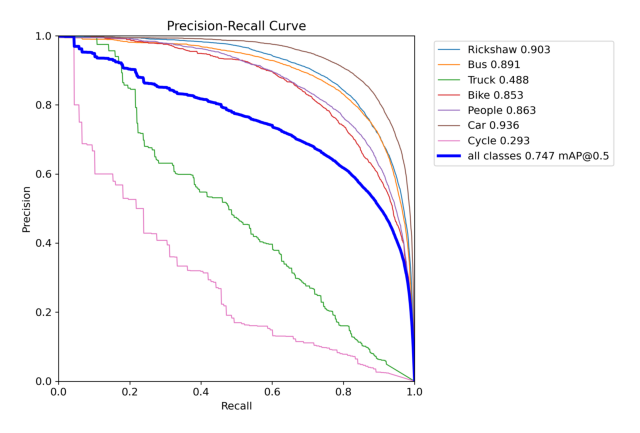

In [6]:
# ============================================================
# 5. Visualize PR curve from train folder
# ============================================================
box_pr_curve_file = list((OUTPUT_FOLDER/"train").glob("*BoxPR_curve*.png"))[0]
img = mpimg.imread(box_pr_curve_file)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
# ============================================================
# 6. Model speed / latency (FPS)
# ============================================================
results = model(str(SPLIT/"test/images"), device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

FPS ≈ 20.293713347898557


In [8]:
#best model

from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Path to your trained model
best_model_path = Path("/kaggle/working/base_yolov11/train/weights/best.pt")

# Load the trained YOLOv11 model
model = YOLO(str(best_model_path))

# ============================================================
# Evaluate on test set
# ============================================================
DATA = "/kaggle/working/traffic_baseline/data_traffic.yaml"

metrics = model.val(
    data=DATA,
    split="test",
    plots=True,           # generates PR curve, confusion matrix, etc.
    project="/kaggle/working/base_yolov11",
    name="val"
)

print("mAP@0.5     :", metrics.box.map50)
print("mAP@[.5:.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)


# ============================================================
# 3. Inference on test images + FPS
# ============================================================
results = model("/kaggle/working/traffic_baseline/yolo_split/test/images", device=0, imgsz=640, verbose=False)
fps = 1000.0 / results[0].speed['inference']
print("FPS ≈", fps)

# ============================================================
# Model complexity (params / GMACs)
# ============================================================
model.info(detailed=True)


Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,283 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1540.9±397.3 MB/s, size: 69.1 KB)


val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels.cache... 2369 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2369/2369 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:26<00:00,  5.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      23544      0.657      0.726      0.751      0.519
              Rickshaw       1947       6157      0.756      0.887       0.91      0.633
                   Bus       1954       5346      0.766      0.877      0.895       0.66
                 Truck        109        125       0.41      0.528      0.505      0.404
                  Bike       1034       1589      0.731      0.815      0.849      0.514
                People       1448       3878      0.723      0.828      0.862      0.548
                   Car       2143       6369        0.8      0.912      0.937      0.711
                 Cycle         77         80      0.409      0.237      0.301      0.161
Speed: 0.2ms preprocess, 7.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/base_yolov11/val2
mAP@0.5     : 0.7513965381378961
mAP@[.5:.95]: 0.518800372995226
Precision   : 0.6565701860832126
Recall      : 0.7262122094841097
WARNING ⚠️ 
inference re

(100, 9416283, 0, 21.3191168)